# Performance Comparison between Darvis and ORBSLAM

INSTRUCTIONS:

1. Run tracy
   ./tracy/capture/build/unix/capture-release -f -o orbslam.tracy
2. Run system
  Darvis:
    cargo run --release ~/datasets/kitti_00_0/ config.yaml
    (after system is done) cp results/output.log ../../results/darvis-output.txt
  ORB SLAM3:
    ./Examples/Monocular/mono_kitti Vocabulary/ORBvoc.txt Examples/Monocular/KITTI00-02.yaml ~/datasets/kitti_00_0/ | tee ../results/orbslam-output.txt

To find where the extra stats are printed, look for the strings "MAP INFO:" and "LBA:" in source code.


In [260]:
darvis_home = "/home/sofiya/darvis-home/"
output_files = {
    "orbslam-10fps": {
        "tracy": "results/orbslam-10fps.tracy",
        "output": "results/orbslam-10fps.txt"
    },
    "darvis-10fps": {
        "tracy": "results/darvis-10fps.tracy",
        "output": "results/darvis-10fps.txt"
    },
    "darvis fxhasher": {
        "tracy": "results/darvis-fxhash.tracy",
    },
    "darvis seahash": {
        "tracy": "results/darvis-seahasher.tracy",
    },
    "darvis default hash": {
        "tracy": "results/darvis-defaulthash.tracy"
    }
}
        

In [269]:
import subprocess
import matplotlib.pyplot as plt
import numpy as np

def ns_to_ms(ns_str):
    return float(ns_str) / 1000000

#### CSVs ####
def process_csv_statistics(csv):
    data = {}
    for line in csv[1:]:
        name, src_file, src_line, total_ns, total_perc, counts, mean_ns, min_ns, max_ns, std_ns = line.split(",")
        data[name] = {
            "mean": ns_to_ms(mean_ns),
            "std": ns_to_ms(std_ns),
            "counts": counts
        }
    return data

def process_csv_unaggregated(csv, process_names):
    data = {}
    for line in csv[1:]:
        name, src_file, src_line, ns_since_start, exec_time_ns = line.split(",")
        if name in data:
            data[name]["dur"].append(ns_to_ms(exec_time_ns))
            data[name]["time"].append(ns_to_ms(ns_since_start))
        else:
            data[name] = {
                "dur": [ns_to_ms(exec_time_ns)],
                "time": [ns_to_ms(ns_since_start)]
            }
            process_names.add(name)
    return data, process_names

#### REGULAR OUTPUT FILES ####
def new_extra_data():
    # Just so we have the same formatting for both darvis and orbslam
    return {
        "map info": {
            "kfs": [],
            "mps": [],
            "avg_mps_per_kf": [],
            "time": [],
        },
        "LBA": {
            "kfs to optimize": [],
            "fixed kfs": [],
            "mps to optimize": [],
            "edges": [],
            "time": [],
        }
    }

def process_output_file_orbslam(file):
    start_time = 0
    data = new_extra_data()
    for line in open(file, "r"):
        try:
            if "START TIME" in line:
                start_time = float(line.split(":")[1]) / 1000 # ms to s
            elif "MAP INFO" in line:
                _, garb = line.split(":")
                time, kfs, mps, avg_mps_per_kf = garb.split(",")
                data["map info"]["kfs"].append(float(kfs))
                data["map info"]["mps"].append(float(mps))
                data["map info"]["avg_mps_per_kf"].append(float(avg_mps_per_kf))
                data["map info"]["time"].append((float(time) / 1000) - start_time)
            elif "LBA" in line:
                _, garb = line.split(":")
                time, kfs_to_optimize, fixed_kfs, mps_to_optimize, edges = garb.split(",")
                data["LBA"]["kfs to optimize"].append(float(kfs_to_optimize))
                data["LBA"]["fixed kfs"].append(float(fixed_kfs))
                data["LBA"]["mps to optimize"].append(float(mps_to_optimize))
                data["LBA"]["edges"].append(float(edges))
                data["LBA"]["time"].append((float(time) / 1000) - start_time)
        except ValueError:
            print(line)
    return data
        
def process_output_file_darvis(file):
    start_time = 0    
    data = new_extra_data()
    for line in open(file, "r"):
        try:
            if "Tracking working on frame 0" in line:
                start_time = float(line.split(" ")[0].split("[")[1].strip())
            elif "MAP INFO" in line:
                time = line.split(" ")[0].split("[")[1].strip()
                _, garb = line.split("MAP INFO:")
                kfs, mps, avg_mps_per_kf = garb.split(",")
                data["map info"]["kfs"].append(float(kfs))
                data["map info"]["mps"].append(float(mps))
                data["map info"]["avg_mps_per_kf"].append(float(avg_mps_per_kf))
                data["map info"]["time"].append(float(time) - start_time)
            elif "LBA" in line:
                time = line.split(" ")[0].split("[")[1].strip()
                _, garb = line.split("LBA:")
                kfs_to_optimize, fixed_kfs, mps_to_optimize, edges = garb.split(",")
                data["LBA"]["kfs to optimize"].append(float(kfs_to_optimize))
                data["LBA"]["fixed kfs"].append(float(fixed_kfs))
                data["LBA"]["mps to optimize"].append(float(mps_to_optimize))
                data["LBA"]["edges"].append(float(edges))
                data["LBA"]["time"].append(float(time) - start_time)
        except ValueError:
            print(line)
    return data
    
results = {}
process_names = set()
for key in output_files:
    # Tracy
    tracy_fn = darvis_home + output_files[key]["tracy"]
    csv_statistics = subprocess \
        .run([darvis_home +"tracy/csvexport/build/unix/csvexport-release", tracy_fn], stdout=subprocess.PIPE) \
        .stdout \
        .decode('utf-8') \
#         .split("\n")[1:-1] # First line is key, last line is empty
    print(csv_statistics)
    csv_unaggregated_counts = subprocess \
        .run([darvis_home +"tracy/csvexport/build/unix/csvexport-release", "-u", tracy_fn], stdout=subprocess.PIPE) \
        .stdout \
        .decode('utf-8') \
        .split("\n")[1:-1] # First line is key, last line is empty
    times, process_names = process_csv_unaggregated(csv_unaggregated_counts, process_names)
    
    # Regular output
    if "output" in output_files[key]:
        output_fn = darvis_home + output_files[key]["output"]
        if "darvis" in key:
            extra_stats = process_output_file_darvis(output_fn)
        else:
            extra_stats = process_output_file_orbslam(output_fn)
    else:
        print(key, "does not have output file")
        extra_stats = new_extra_data()

    results[key] = {
        "times": times,
        "extra stats": extra_stats
    }


name,src_file,src_line,total_ns,total_perc,counts,mean_ns,min_ns,max_ns,std_ns
update_local_keyframes,/home/sofiya/darvis-home/darvis-orbslam3/src/Tracking.cc,3543,5605885,0.049112,67,83669,23913,219182,36786.911763
local_bundle_adjustment:add_kf_vertices,/home/sofiya/darvis-home/darvis-orbslam3/src/Optimizer.cc,1255,209318,0.001834,34,6156,2417,11001,2630.756234
local_mapping,/home/sofiya/darvis-home/darvis-orbslam3/src/LocalMapping.cc,78,4835988658,42.367452,36,134333018,27254376,256041146,49286896.245558
global_bundle_adjustment,/home/sofiya/darvis-home/darvis-orbslam3/src/Optimizer.cc,57,1619200,0.014186,1,1619200,1619200,1619200,-nan
update_local_points,/home/sofiya/darvis-home/darvis-orbslam3/src/Tracking.cc,3506,39437624,0.345508,67,588621,66821,1327961,257259.918173
local_bundle_adjustment,/home/sofiya/darvis-home/darvis-orbslam3/src/Optimizer.cc,1147,2259587222,19.795943,34,66458447,11705818,113161960,26252196.450657
mappoint_culling,/home/sofiya/darvis-home/darvis-orbslam3/sr

darvis fxhasher does not have output file
name,src_file,src_line,total_ns,total_perc,counts,mean_ns,min_ns,max_ns,std_ns
track_reference_keyframe,src/actors/tracking_backend.rs,416,24194078,0.080648,1,24194078,24194078,24194078,-nan
insert_keyframe,src/map/map.rs,131,586054871,1.953545,23,25480646,341657,52844170,17298930.956859
track,src/actors/tracking_backend.rs,162,1445901940,4.819743,27,53551923,1464270,124689639,21276242.322500
optimize_pose,src/modules/optimizer.rs,68,263041025,0.876816,50,5260820,324301,8799447,1874521.706145
update_local_points,src/actors/tracking_backend.rs,798,18668763,0.062230,25,746750,61470,1420416,396736.520346
create_new_mappoints,src/actors/local_mapping.rs,293,6545517943,21.818711,23,284587736,44983377,600810852,143765279.617976
global_bundle_adjustment,src/modules/optimizer.rs,267,1672539,0.005575,1,1672539,1672539,1672539,-nan
update_local_keyframes,src/actors/tracking_backend.rs,700,13149547,0.043832,25,525981,18778,988255,253886.460043
local_bundl

In [264]:
def draw_duration_graphs(results):
    # Draws every single process
    plt.figure(figsize=(8, 6))
    relevant_process_names = [
        "track",
        "local_mapping",
        "create_new_mappoints",
        "mappoint_culling",
        "keyframe_culling",
        "local_bundle_adjustment"
    ]
    for process in relevant_process_names:
        try:
            for exp in results:
                x_values = results[exp]["times"][process]["time"]
                y_values = results[exp]["times"][process]["dur"]
                plt.plot(x_values, y_values, label=exp, marker='o', linestyle='-', markersize=6)

            plt.xlabel('Time Since Beginning of Execution')
            plt.ylabel('Duration')
            plt.title("Duration of " + process)
            plt.legend()
            plt.show()
        except:
            print("Does not have key", process);

def plot_one_process(experiments, process):
    # Draws just one process if you know what you want
    plt.figure(figsize=(8, 6))
    for exp in experiments:
        x_values = experiments[exp]["times"][process]["time"]
        y_values = experiments[exp]["times"][process]["dur"]
        plt.plot(x_values, y_values, label=exp, marker='o', linestyle='-', markersize=6)

    plt.xlabel('Time Since Beginning of Execution')
    plt.ylabel('Duration')
    plt.title("Duration of " + process)
    plt.legend()
    plt.show()

def plot_one_extra_stat(experiments, stat_name, secondary_stat_name):
    # Plot non-timing stats from the regular output file
    plt.figure(figsize=(8, 6))
    for exp in experiments:
        only_stats = experiments[exp]["extra stats"][stat_name]
        x_values = only_stats["time"]
        y_values = only_stats[secondary_stat_name]
        label = exp + " , " + secondary_stat_name
        plt.plot(x_values, y_values, label=label, marker='o', linestyle='-', markersize=6)

    plt.xlabel('Time Since Beginning of Execution')
    plt.ylabel('Amount')
    plt.title(stat_name + ", " + secondary_stat_name)
    plt.legend()
    plt.show()


## Overview

13.633990793814432
track_reference_keyframe [11.965362333333337, 14.997444]
track_local_map [2.667360784946237, 2.4758236865671637]
8.831241463917527
keyframe_culling [1.1017705510204083, 5.076337171428571]
create_new_mappoints [61.29600757142857, 47.86473111111111]
mappoint_culling [2.4706717346938776, 0.1495753333333333]
local_bundle_adjustment [50.518495765957454, 66.45844770588235]
118.9930152244898


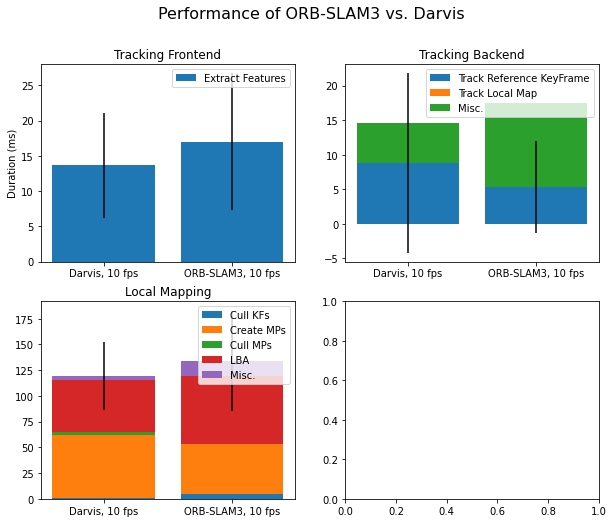

In [270]:
# To see the duration of each task over time:
# experiments_I_care_about = dict((k, results[k]) for k in ('darvis-10fps', 'orbslam-10fps'))
# draw_duration_graphs(experiments_I_care_about)

def draw_bar_plot(experiment1, experiment1_name, experiment2, experiment2_name):
    # Create a figure with four subplots side by side
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    systems = [experiment1_name, experiment2_name]

    def draw_one_bar_plot(ax, categories, categories_pretty, title, draw_ylable=False):
        x = np.arange(len(categories))     
        
        bottom = [0,0]

        for i in range(0, len(categories)):
            value = categories[i]
            label = categories_pretty[i]
            
            if i == len(categories) - 1:
                # For the very last item, either add in anything extra as misc
                # or (if there is only one item) plot it normally
                values = [
                    np.mean(experiment1["times"][value]["dur"]) - bottom[0],
                    np.mean(experiment2["times"][value]["dur"]) - bottom[1],
                ]
                # Errs are for entire loop, not each subtask
                errs = [
                    np.std(experiment1["times"][value]["dur"]),
                    np.std(experiment2["times"][value]["dur"]),
                ]
                print(np.mean(experiment1["times"][value]["dur"]))
                ax.bar(systems, values, yerr=errs, bottom=bottom, label=label)
            else:
                values = [
                    np.mean(experiment1["times"][value]["dur"]),
                    np.mean(experiment2["times"][value]["dur"]),
                ]
                print(value, values)

                ax.bar(systems, values, bottom=bottom, label=label)
            bottom = np.add(bottom, values)
            
        # Add labels and title
        if draw_ylable:
            ax.set_ylabel('Duration (ms)')
        ax.set_title(title)
        ax.legend()

    draw_one_bar_plot(
        axes[0,0],
        ['extract_features'],
        ["Extract Features"],
        "Tracking Frontend",
         True
    )
    draw_one_bar_plot(
        axes[0,1],
        ['track_reference_keyframe', 'track_local_map', 'track'],
        ["Track Reference KeyFrame", "Track Local Map", "Misc."],
        "Tracking Backend"
    )
    draw_one_bar_plot(
        axes[1,0],
        [ 'keyframe_culling', "create_new_mappoints", "mappoint_culling", "local_bundle_adjustment", "local_mapping"], #'insert_keyframe',
        [ "Cull KFs", "Create MPs", "Cull MPs", "LBA", "Misc."], # Insert KF
        "Local Mapping"
    )
#     draw_one_bar_plot(
#         axes[0, 0],
#         ['extract_features'],
#         ["Extract Features"],
#         "Tracking Frontend"
#     )


    plt.suptitle('Performance of ORB-SLAM3 vs. Darvis', fontsize=16)

    fig.show()


# 'track_local_map', 'insert_keyframe', 'track', 
# 'update_local_keyframes',
# 'global_bundle_adjustment', 'search_local_points', 
# 'create_new_keyframe',

# track
# 'optimize_pose',
# 'track_reference_keyframe', 'track_with_motion_model', 
#'search_in_neighbors', 'local_bundle_adjustment::discard',
# 'local_mapping', 'update_connections', 'update_local_points', 


# To compare avgs:
draw_bar_plot(
    results["darvis-10fps"], "Darvis, 10 fps",
    results["orbslam-10fps"], "ORB-SLAM3, 10 fps"
)


## Local mapping deep dive

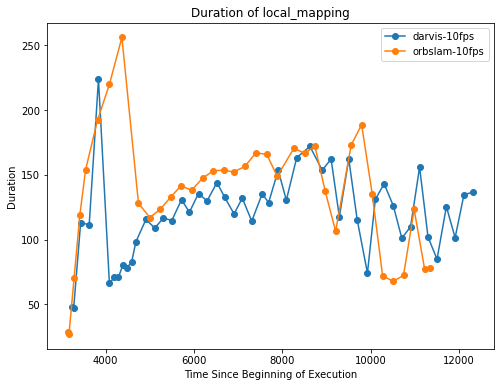

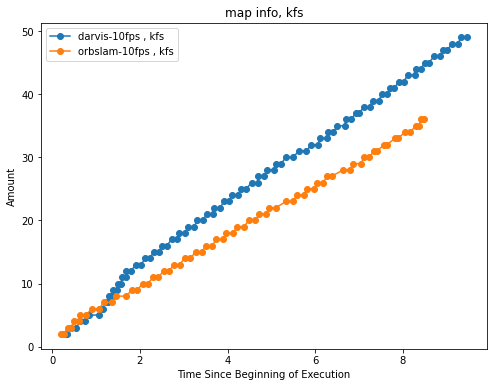

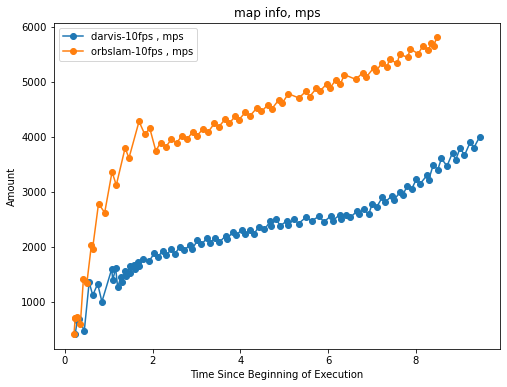

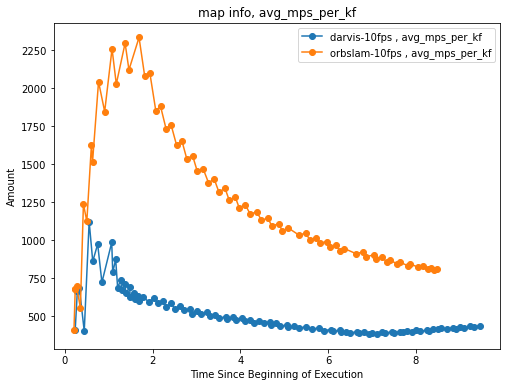

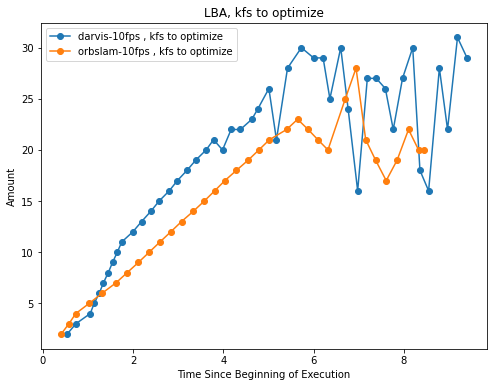

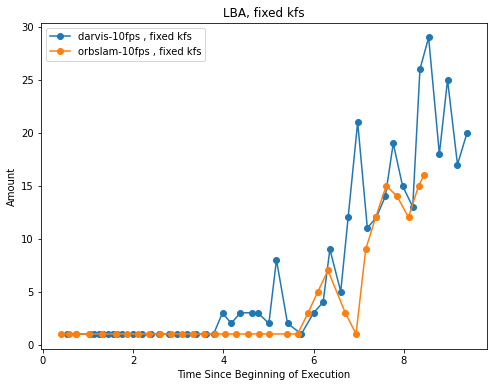

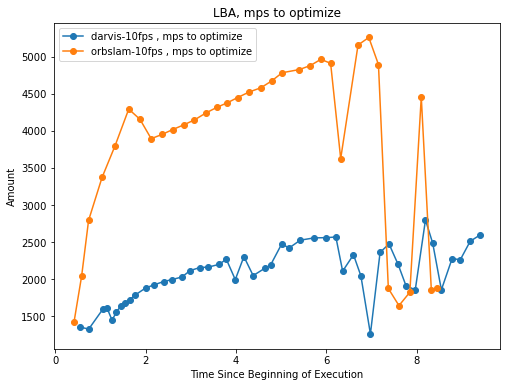

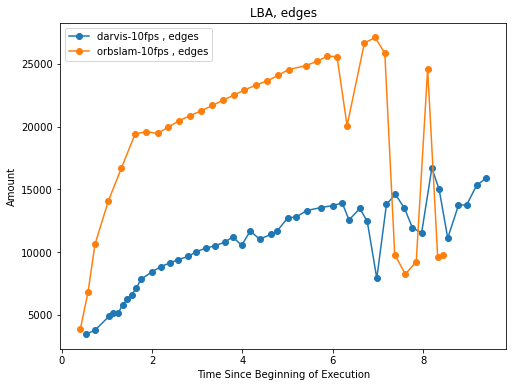

In [180]:
experiments_I_care_about = dict((k, results[k]) for k in ('darvis-10fps', 'orbslam-10fps'))
# draw_duration_graphs(experiments_I_care_about),
plot_one_process(experiments_I_care_about, "local_mapping")
plot_one_extra_stat(experiments_I_care_about, "map info", "kfs")
plot_one_extra_stat(experiments_I_care_about, "map info", "mps")
plot_one_extra_stat(experiments_I_care_about, "map info", "avg_mps_per_kf")


plot_one_extra_stat(experiments_I_care_about, "LBA", "kfs to optimize")
plot_one_extra_stat(experiments_I_care_about, "LBA", "fixed kfs")
plot_one_extra_stat(experiments_I_care_about, "LBA", "mps to optimize")
plot_one_extra_stat(experiments_I_care_about, "LBA", "edges")

## Misc ... Comparing hashing strategies

In [140]:
# experiments_I_care_about = dict((k, results[k]) for k in ('darvis fxhasher', 'darvis seahash', 'darvis default hash'))
# draw_duration_graphs(experiments_I_care_about)

Comparing hashing strategies
